Fixed colorbar range: vmin=1 → vmax=316759.54


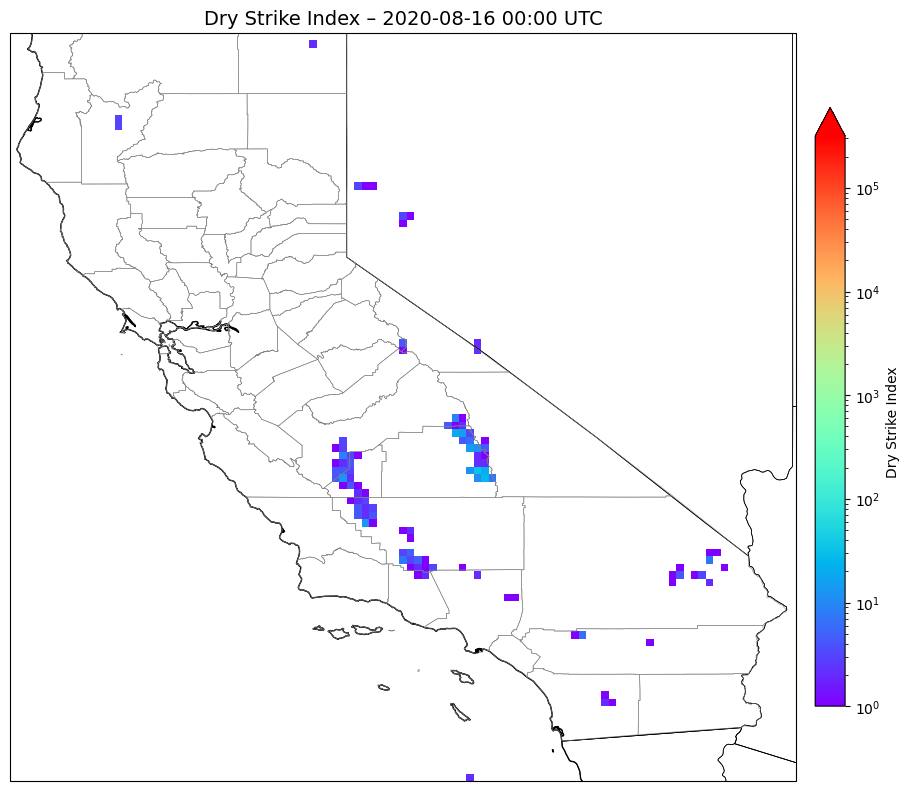

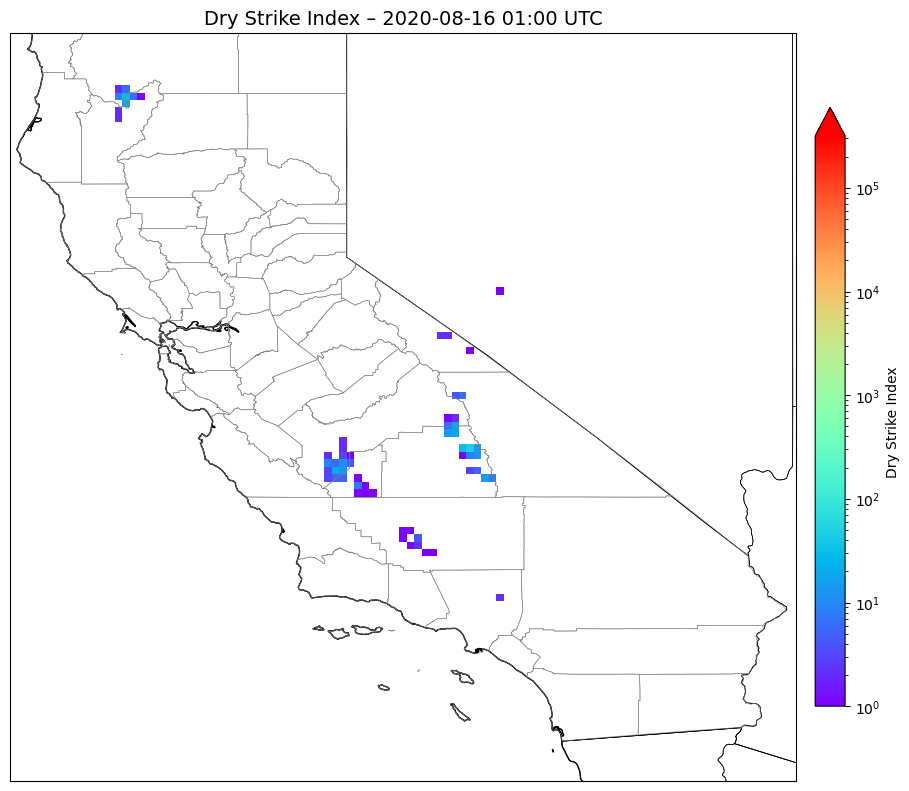

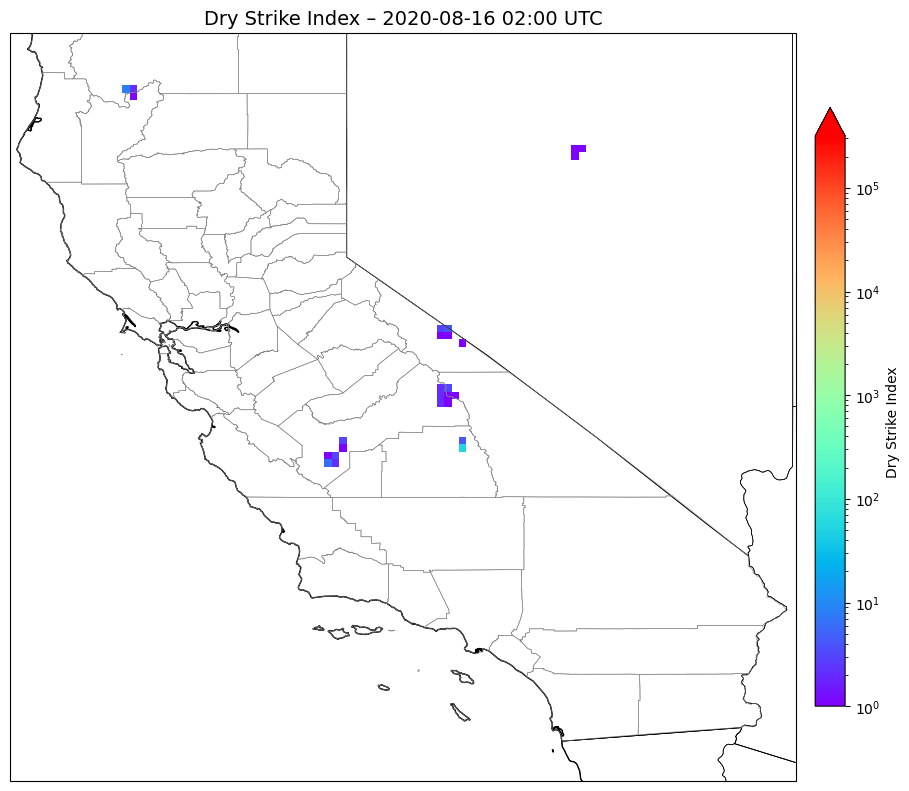

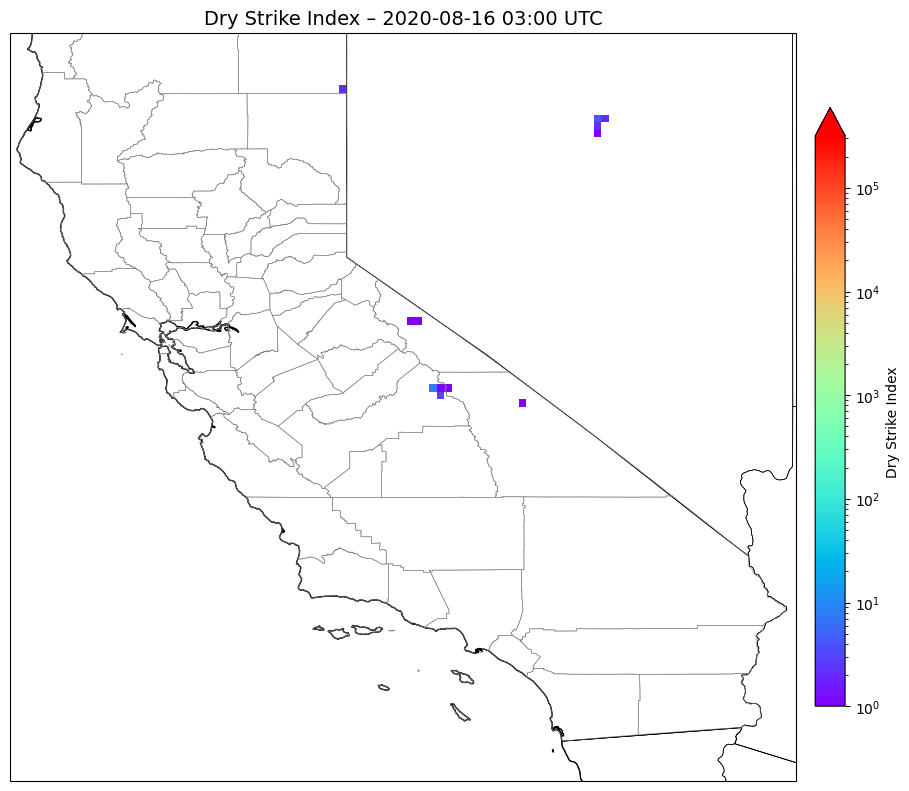

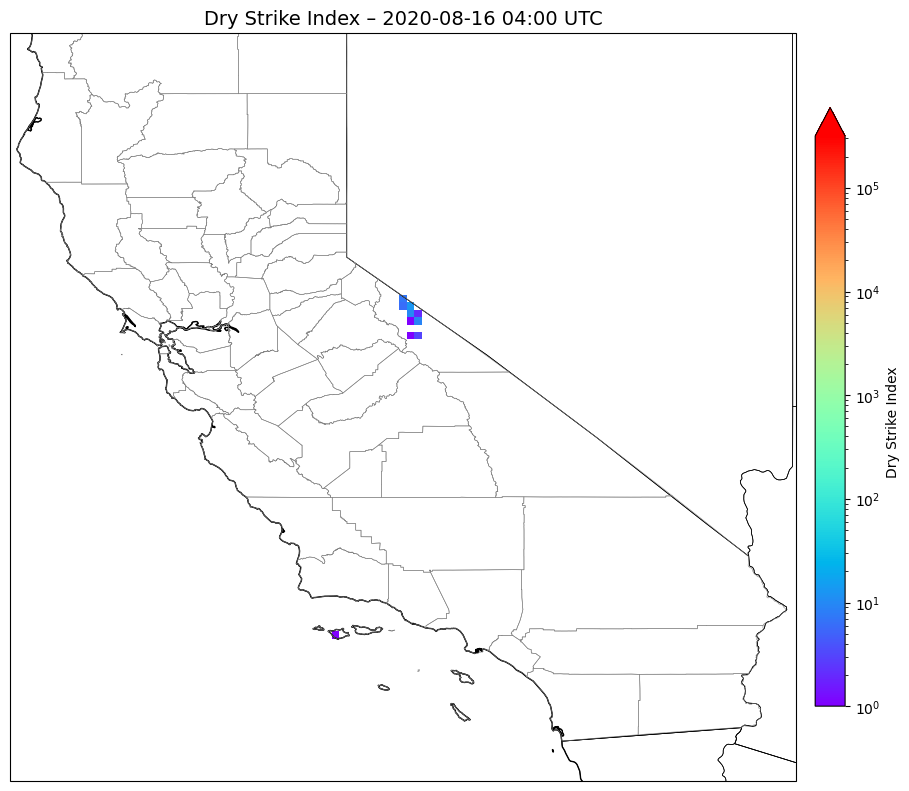

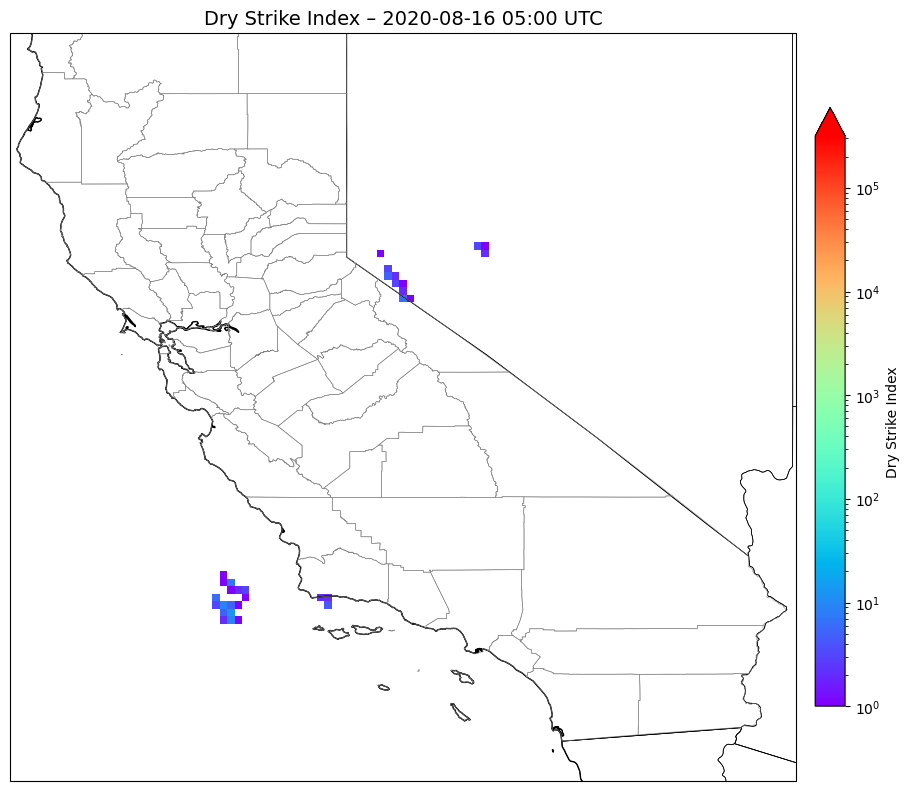

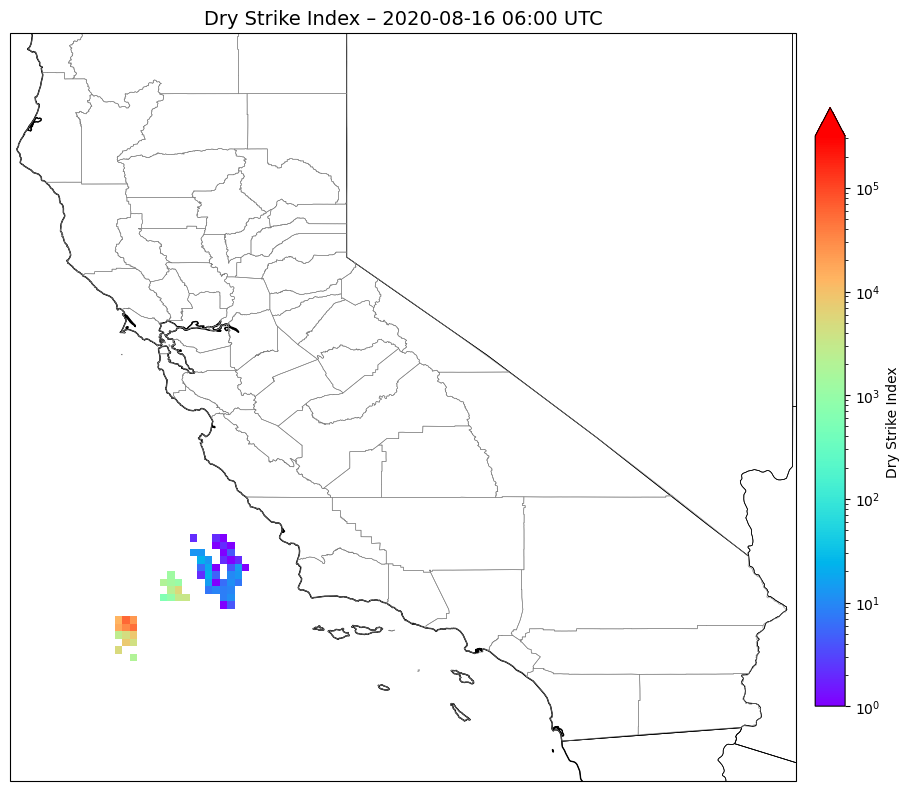

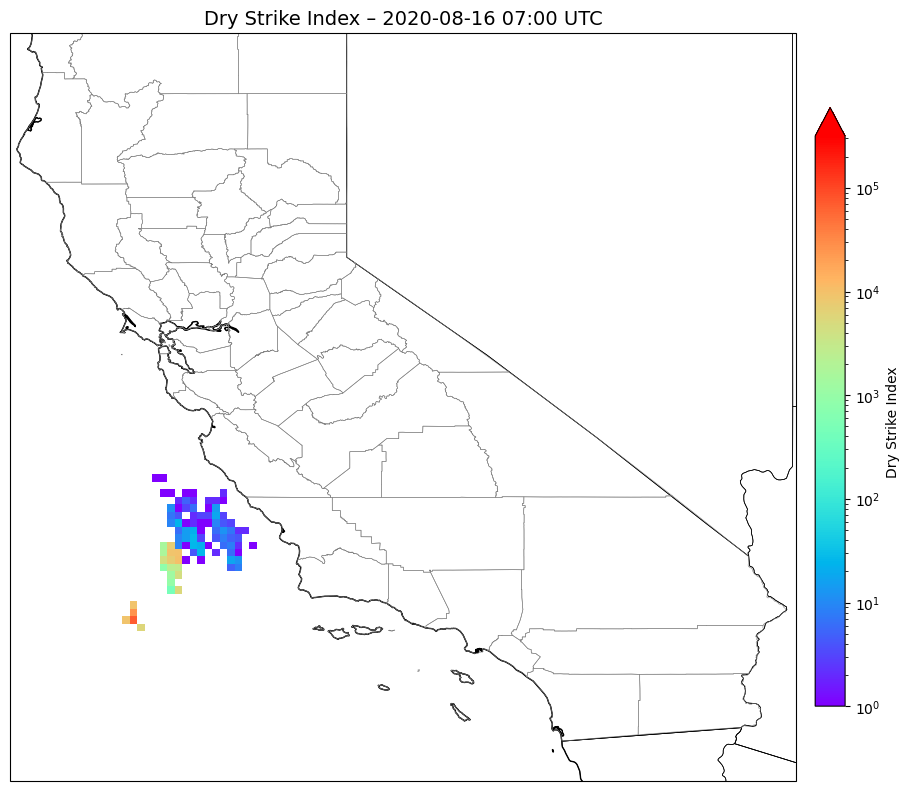

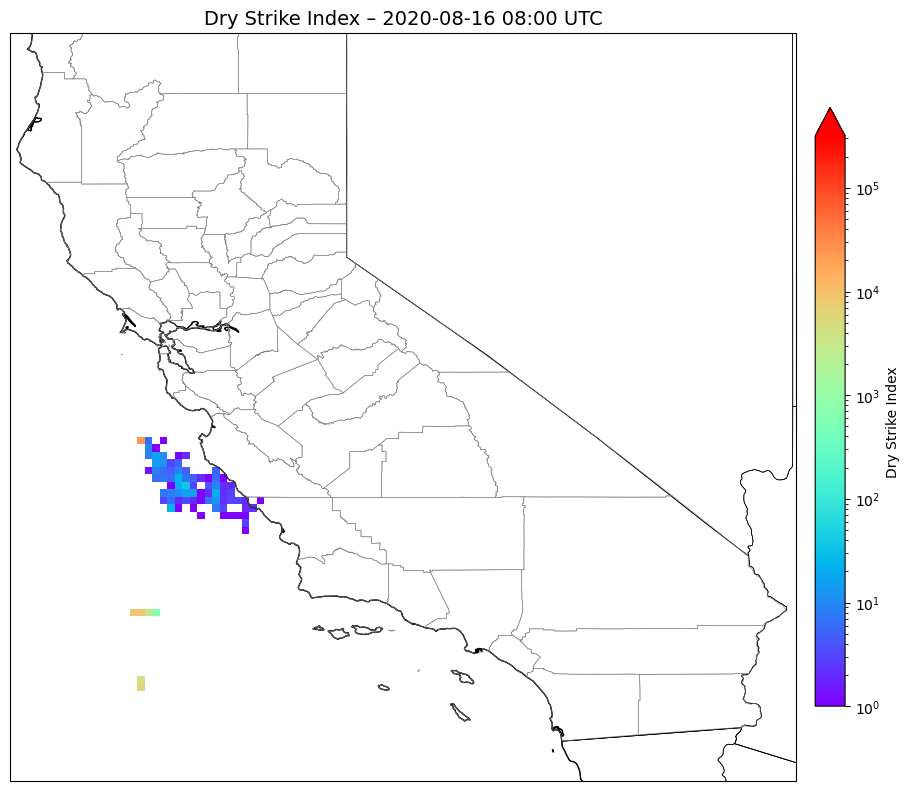

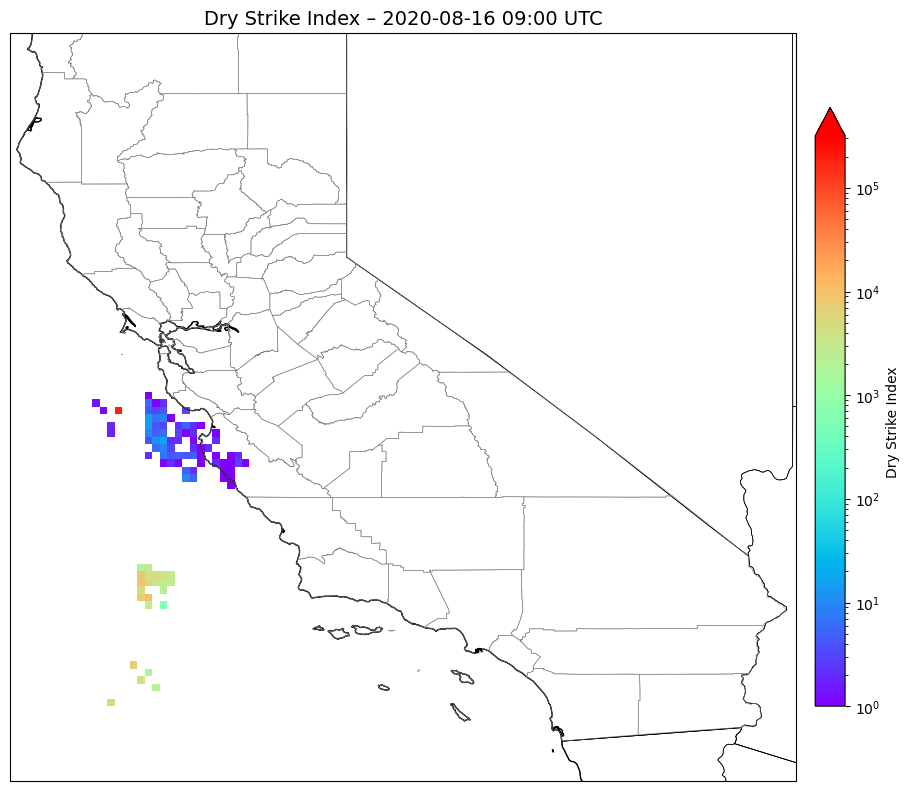

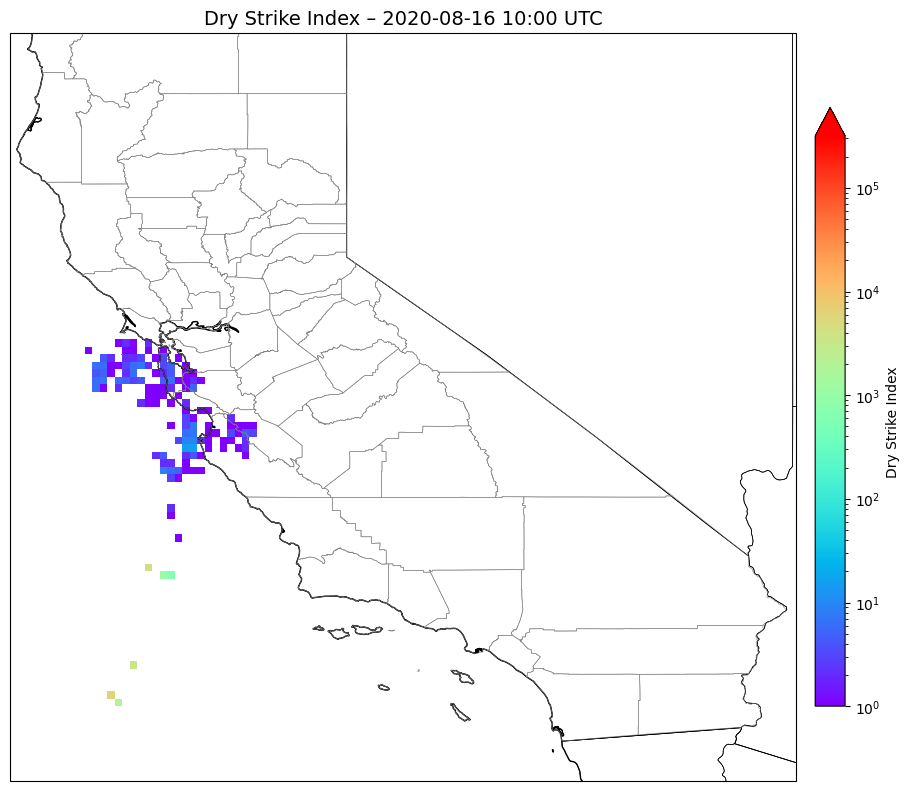

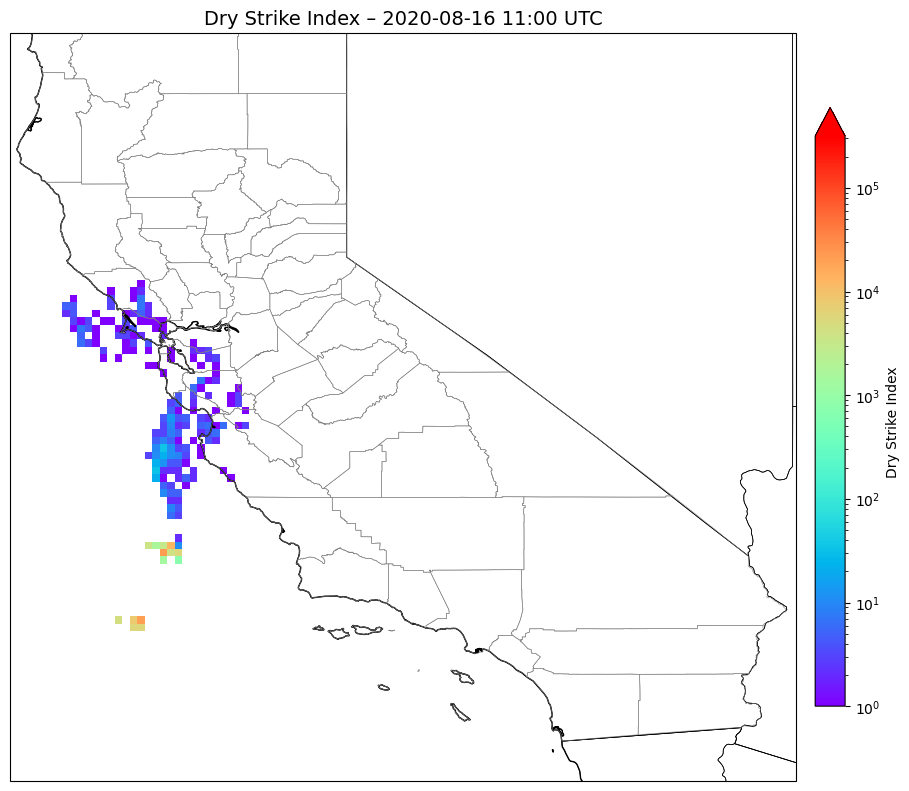

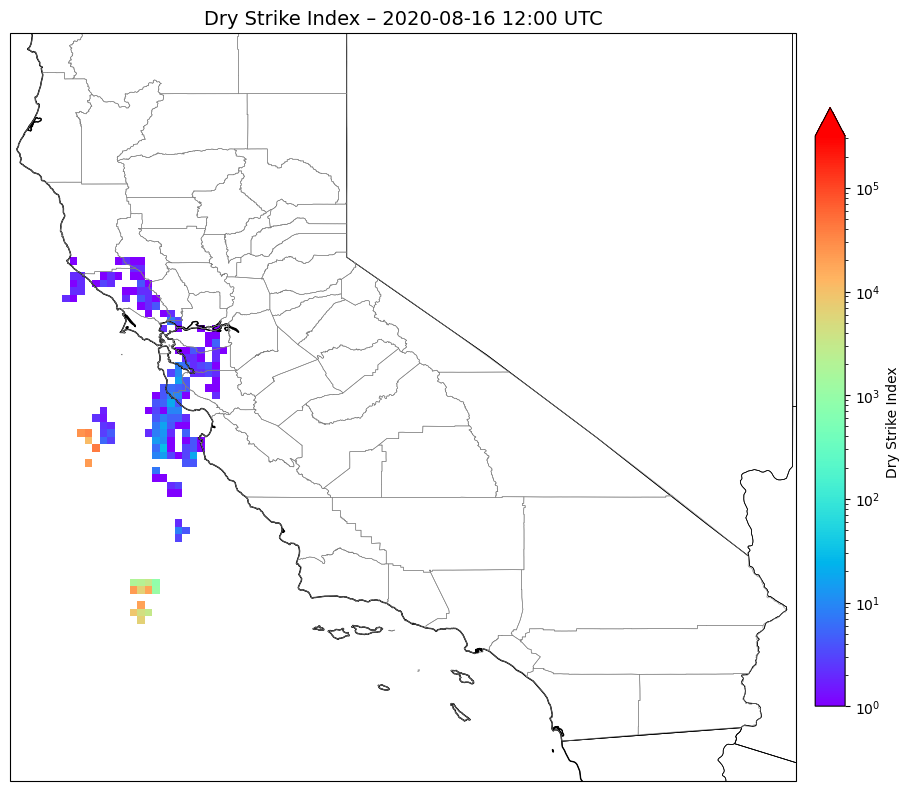

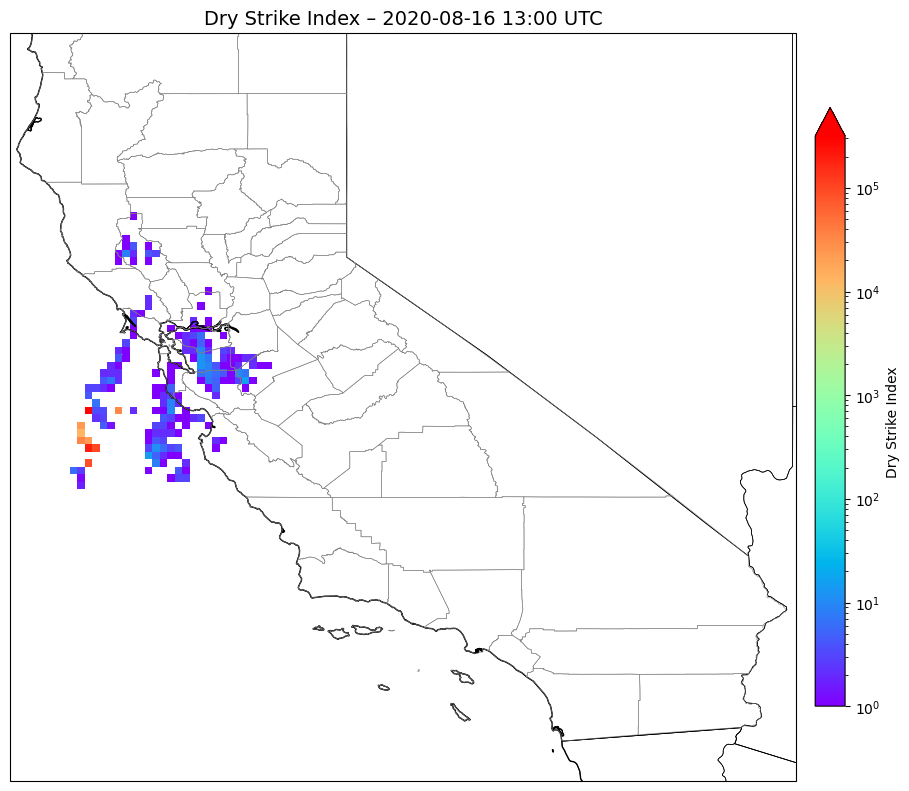

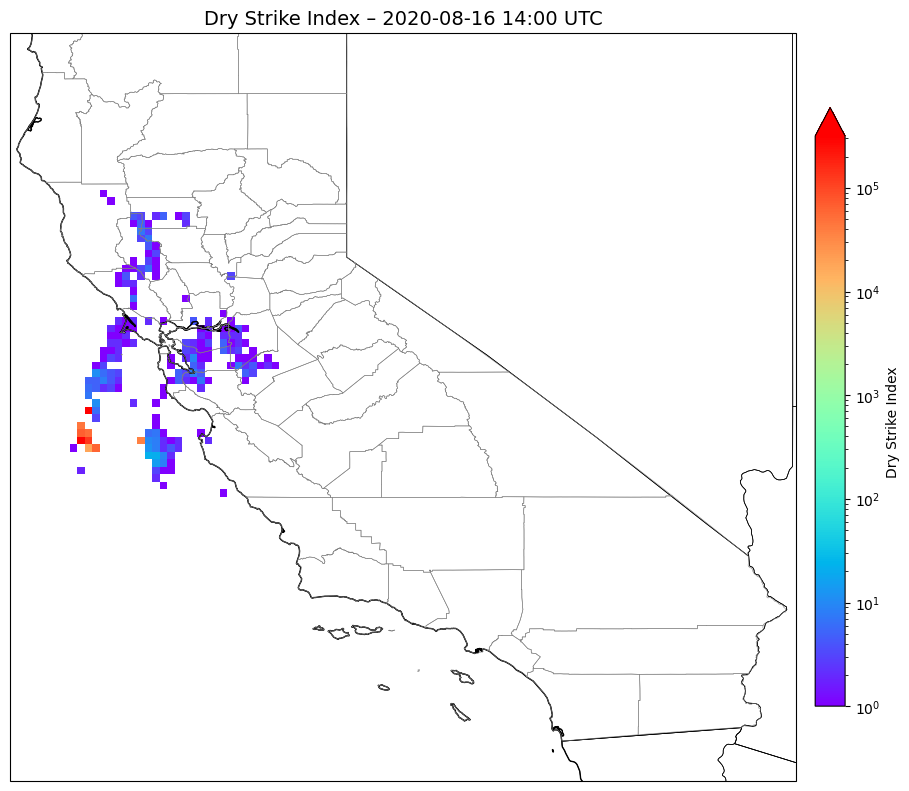

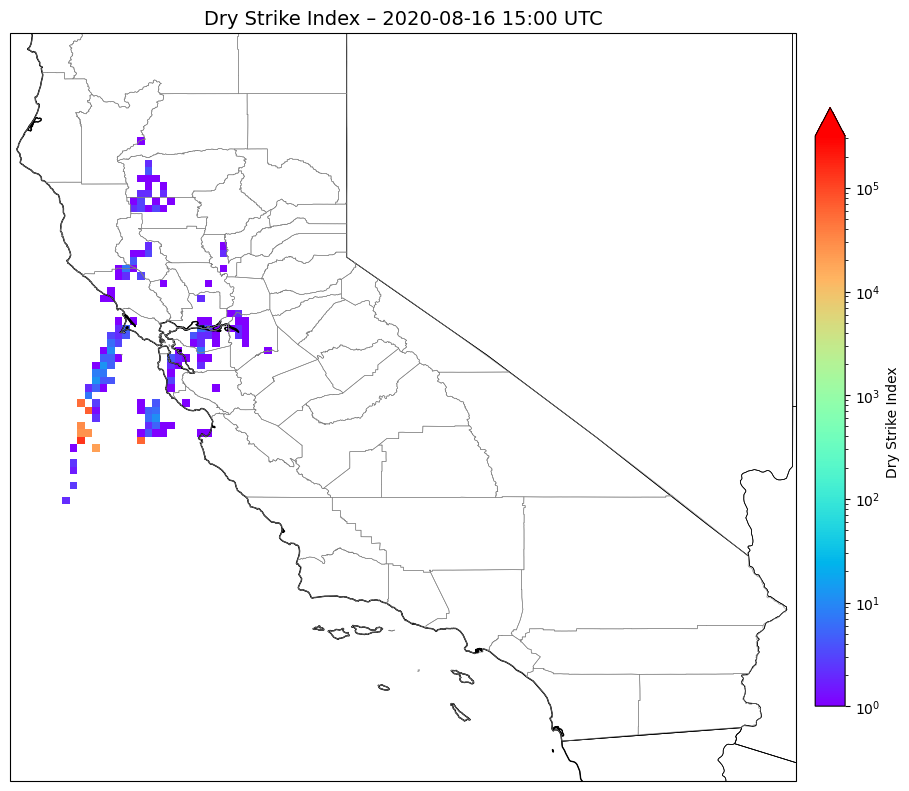

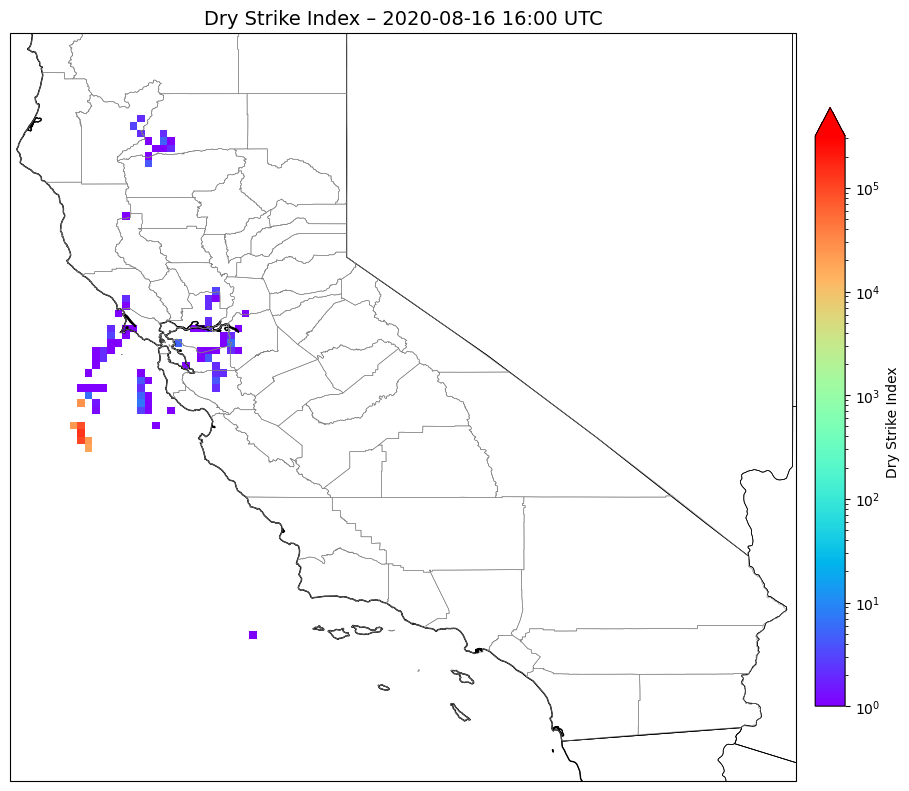

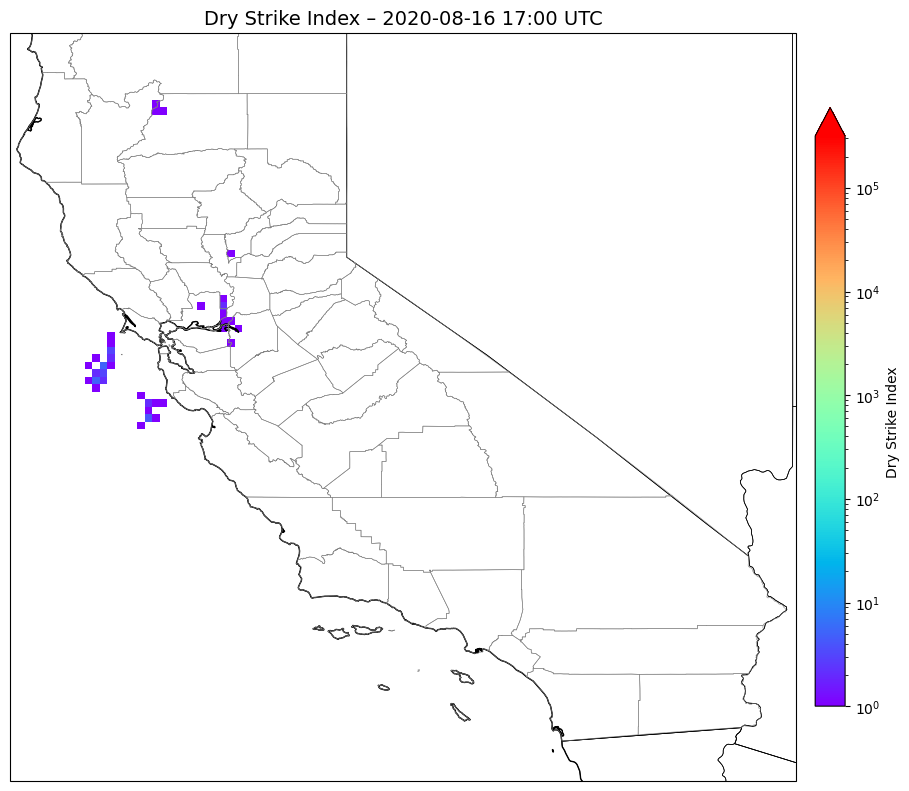

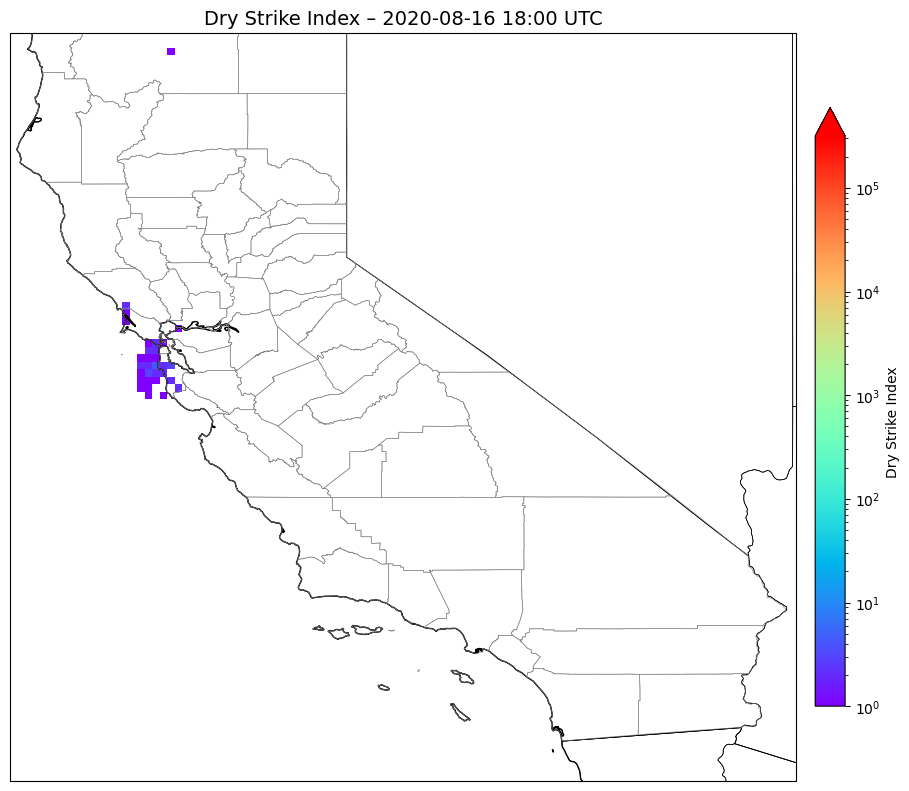

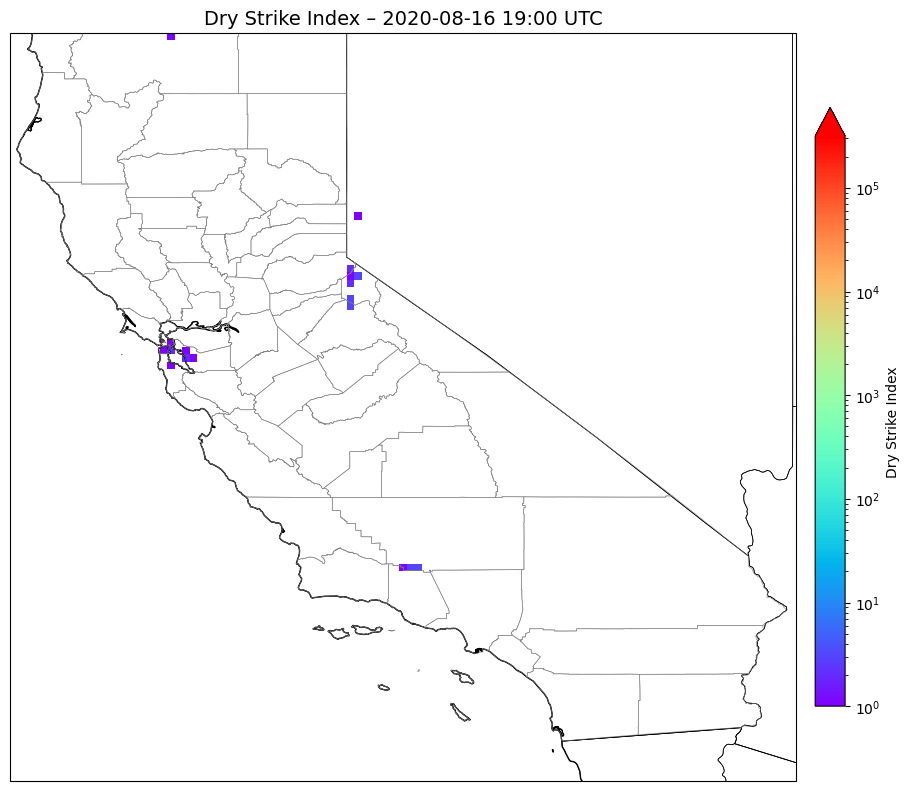

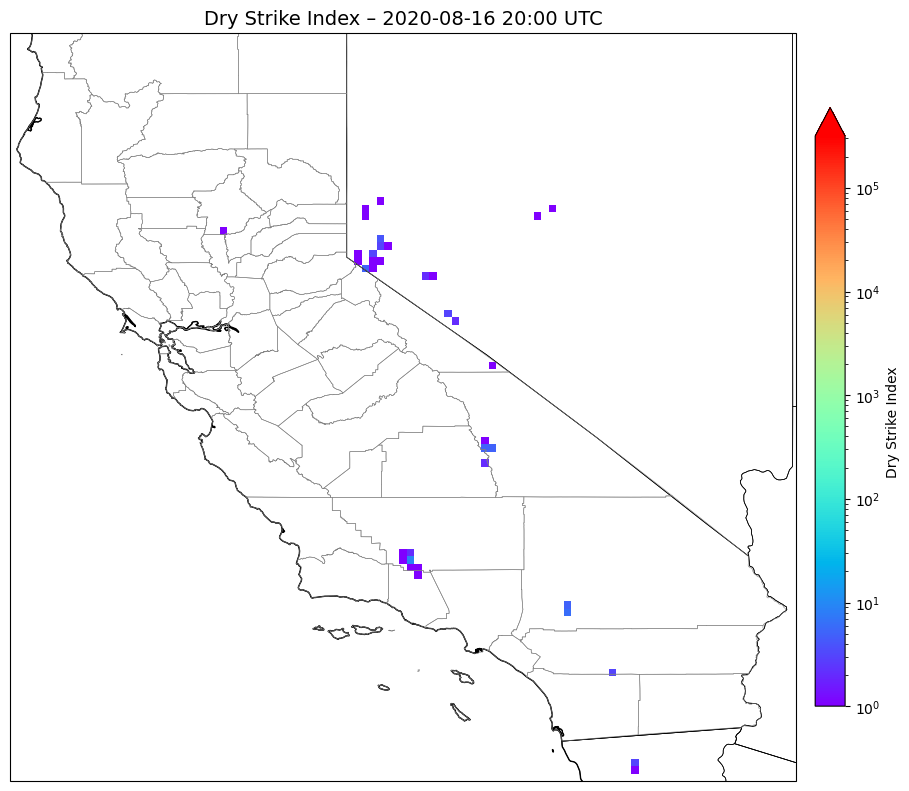

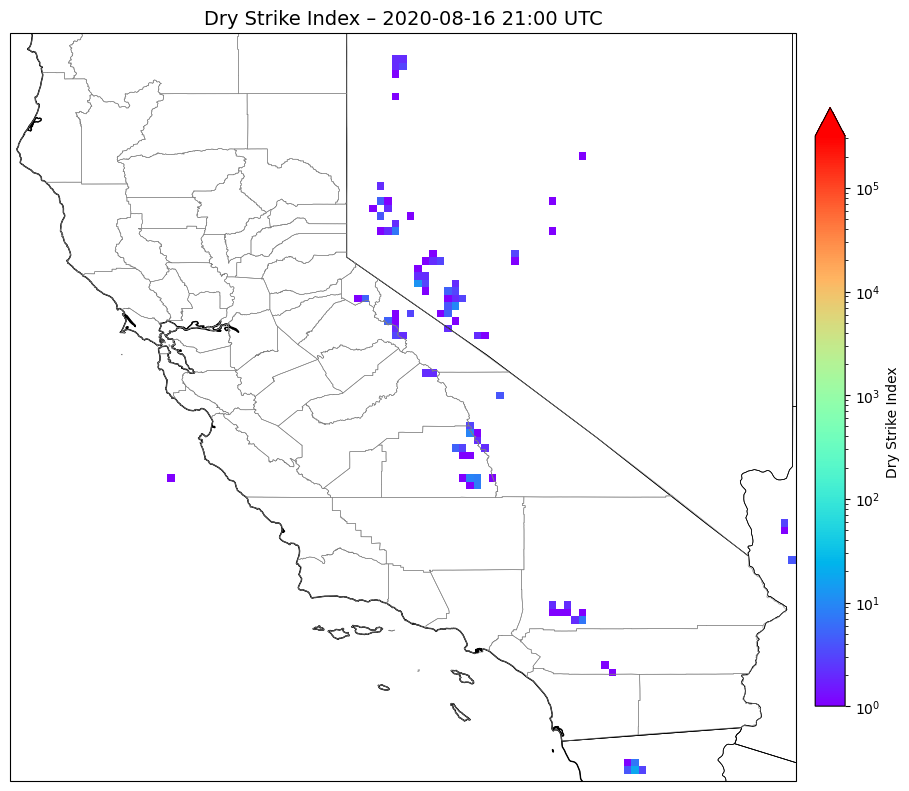

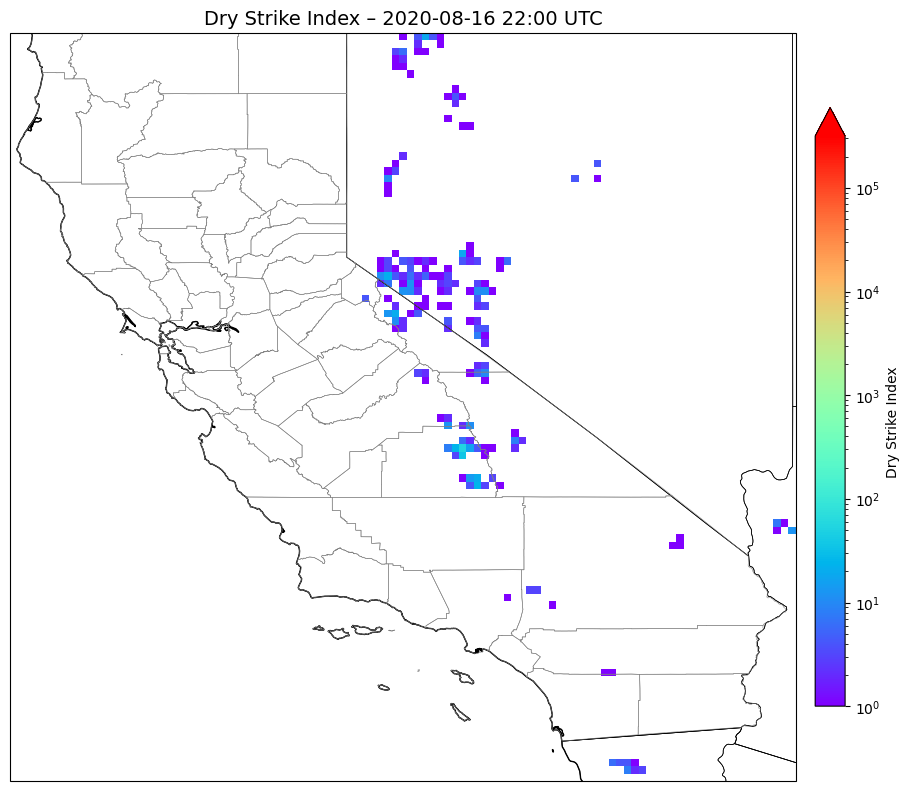

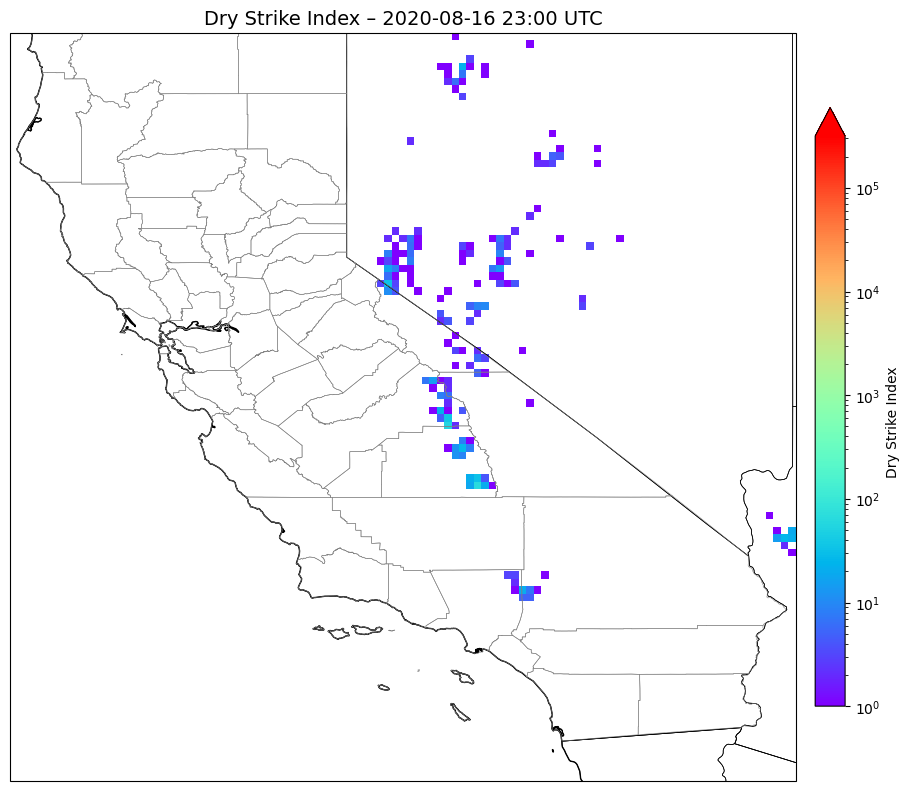

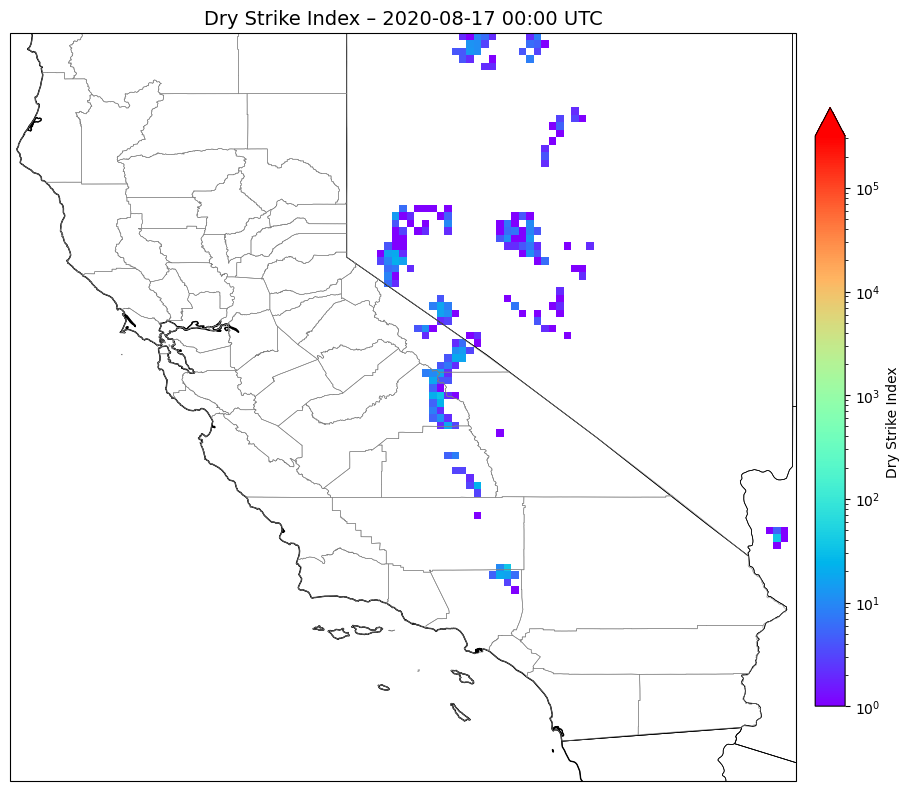

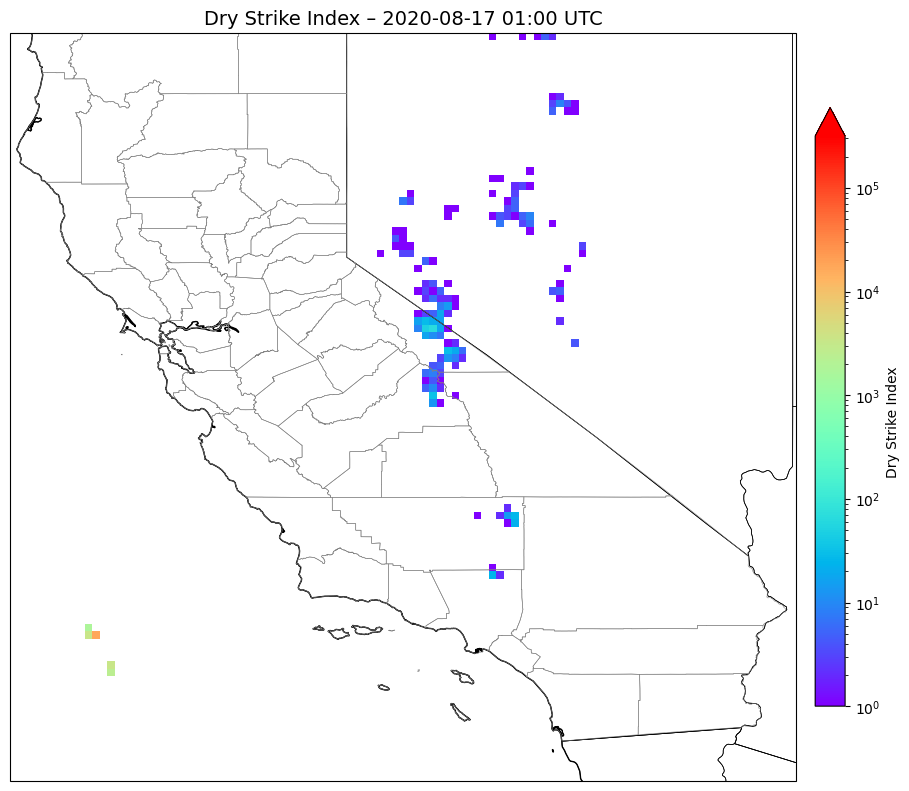

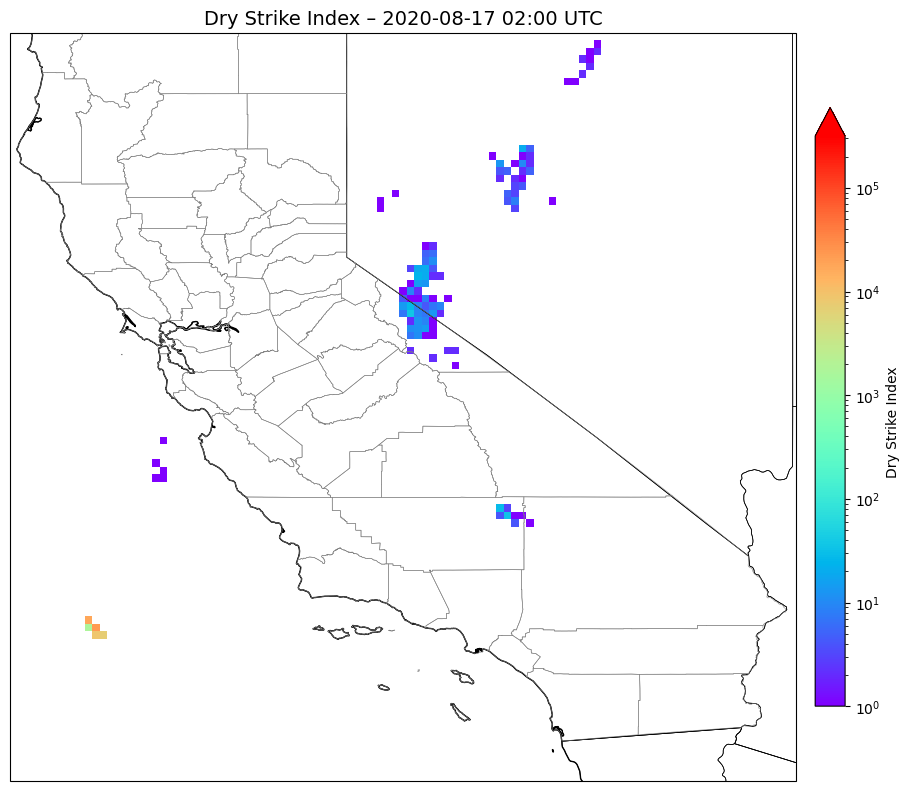

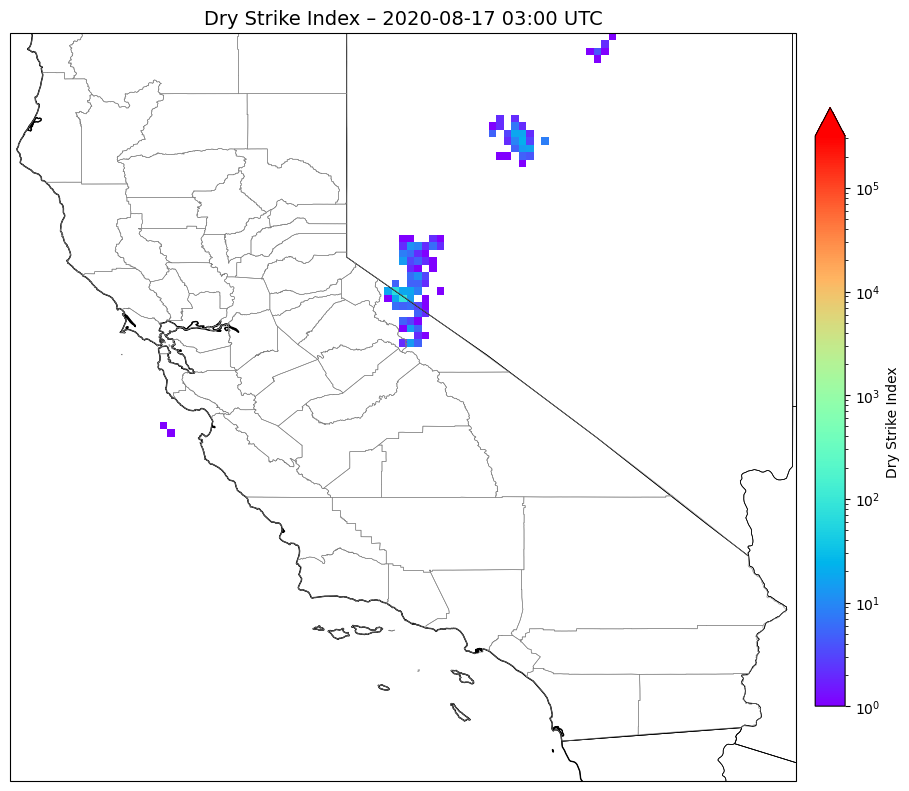

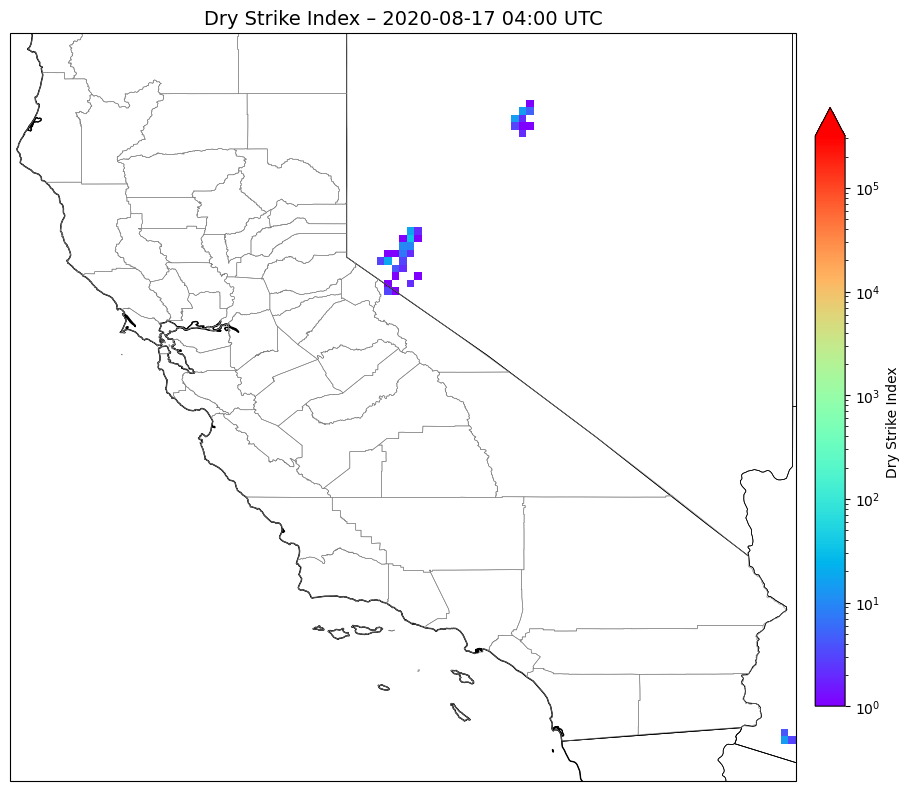

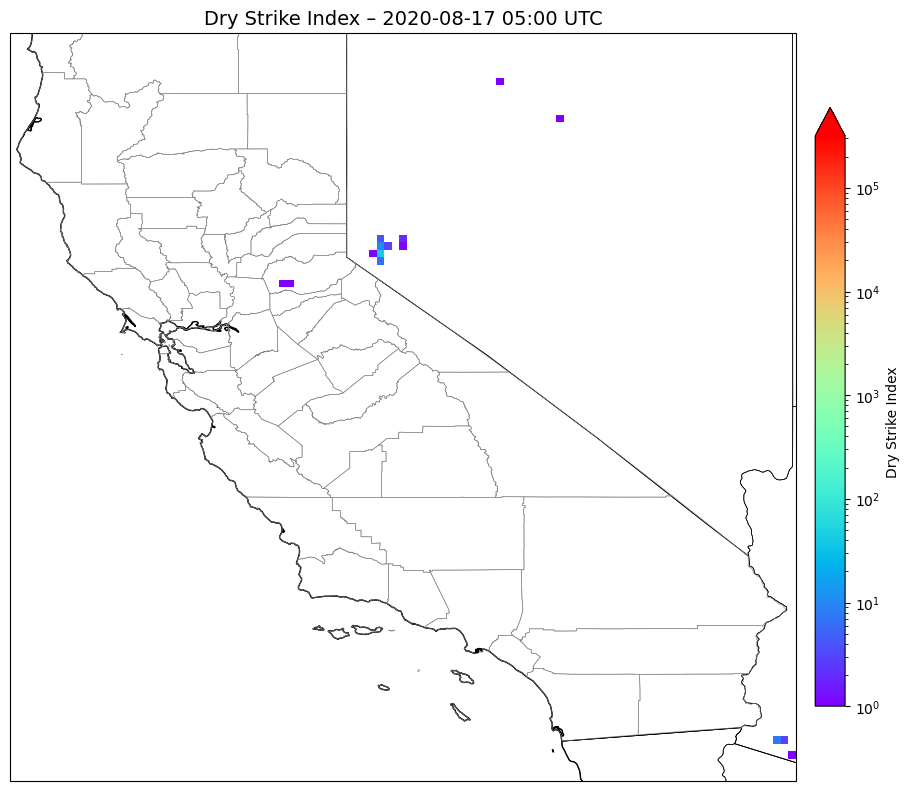

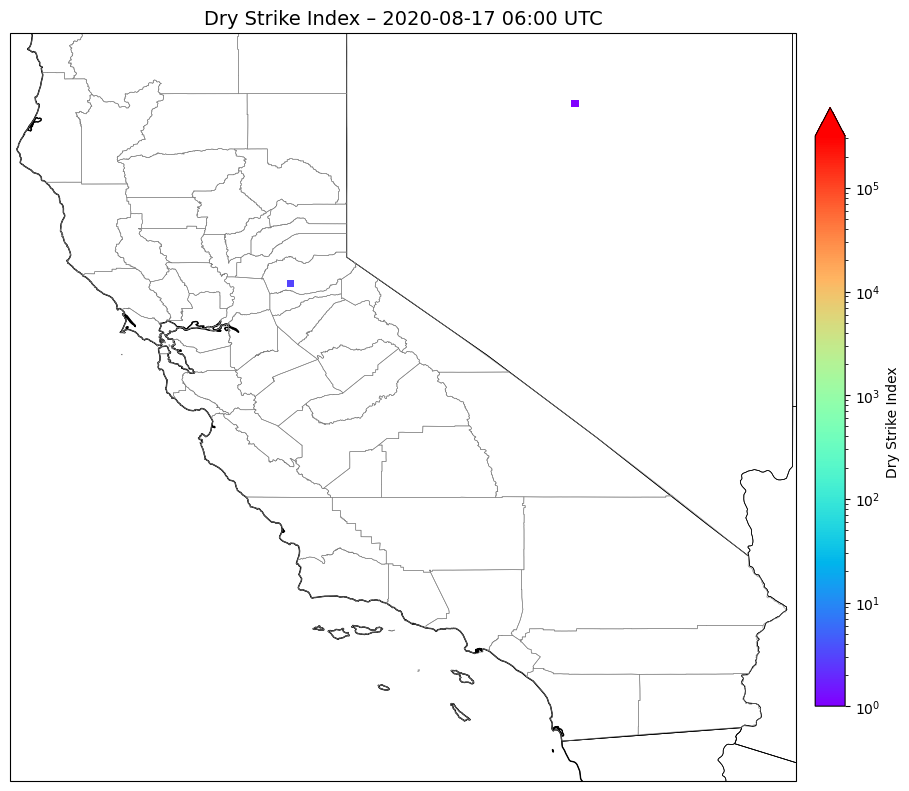

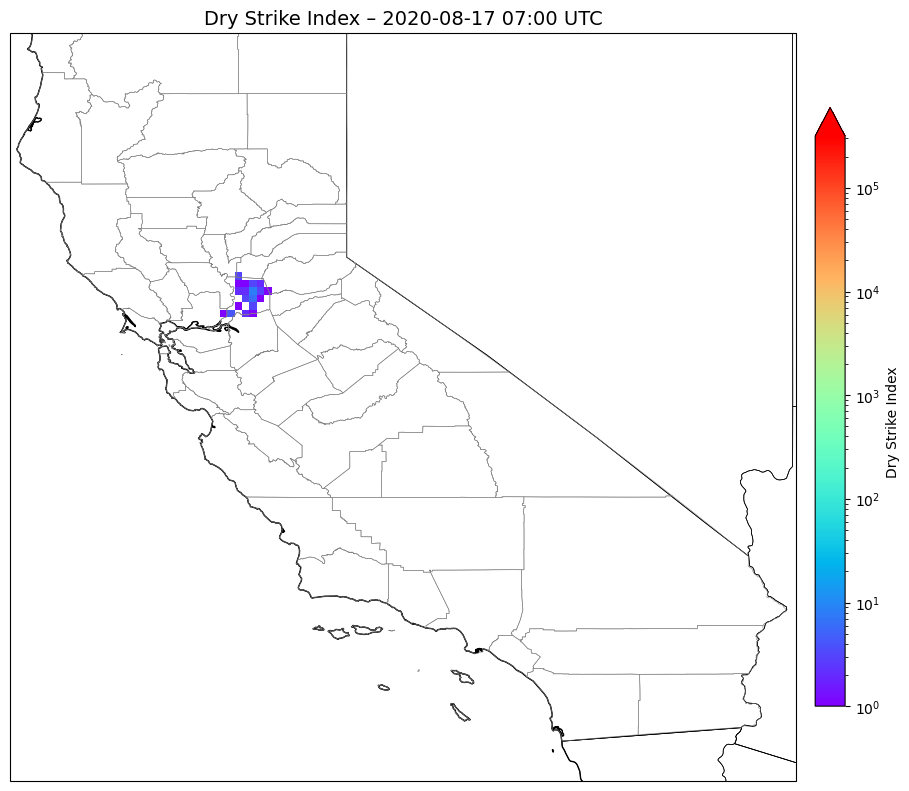

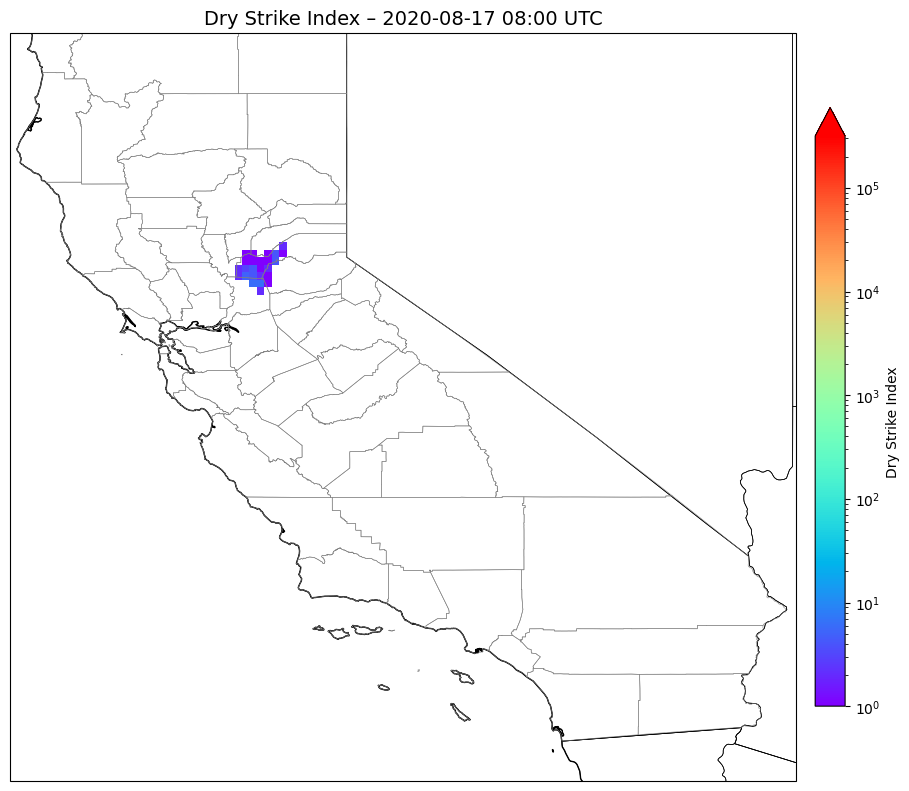

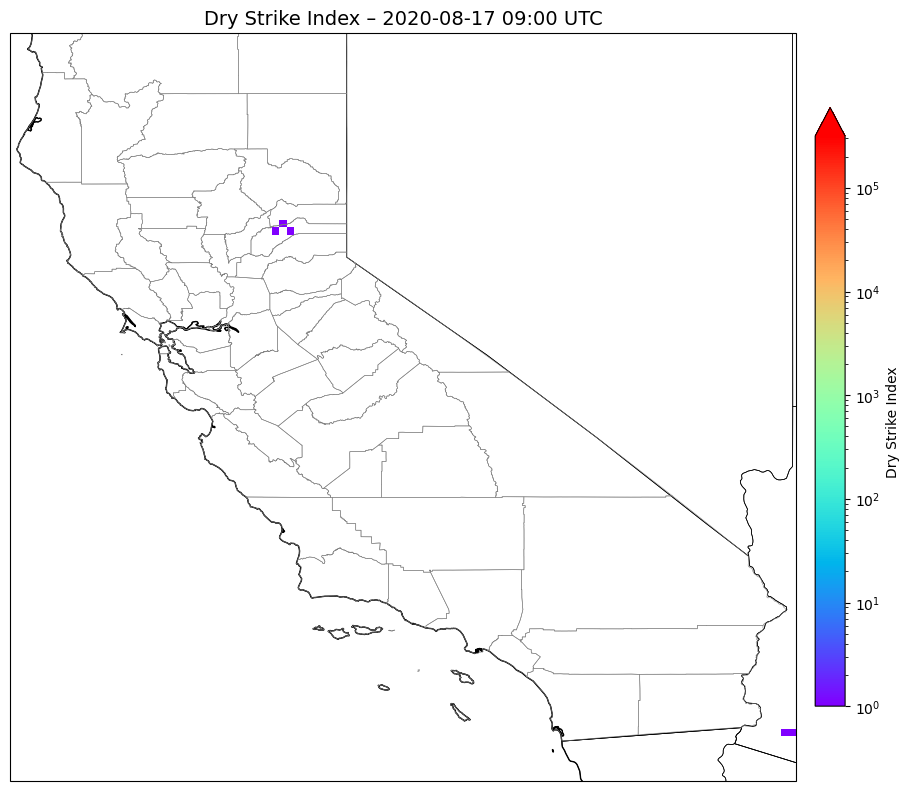

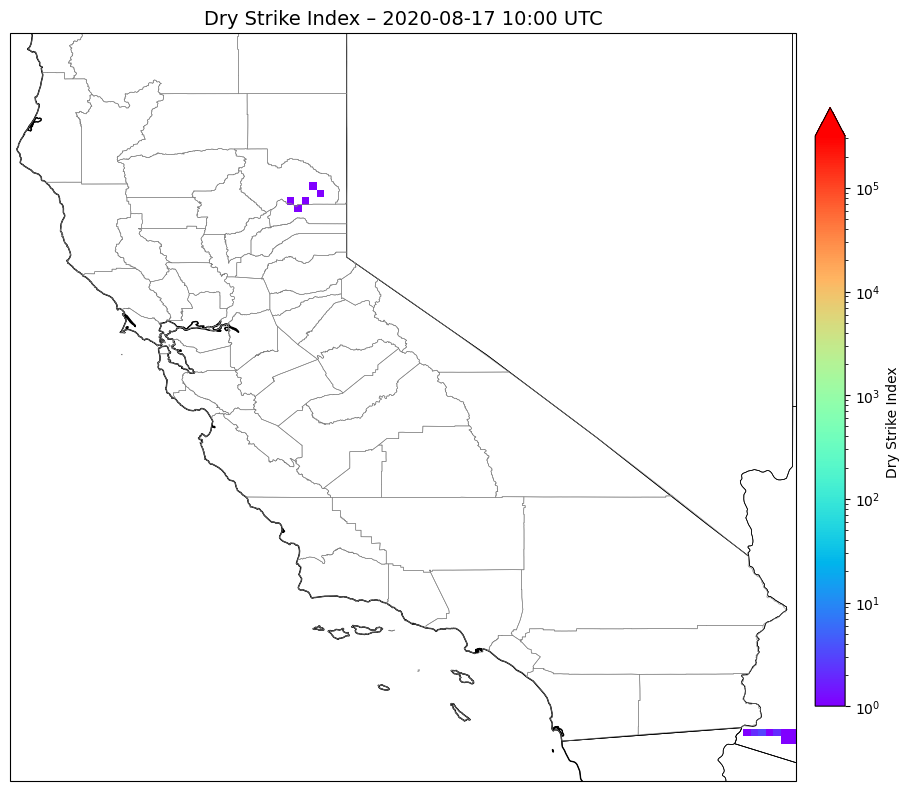

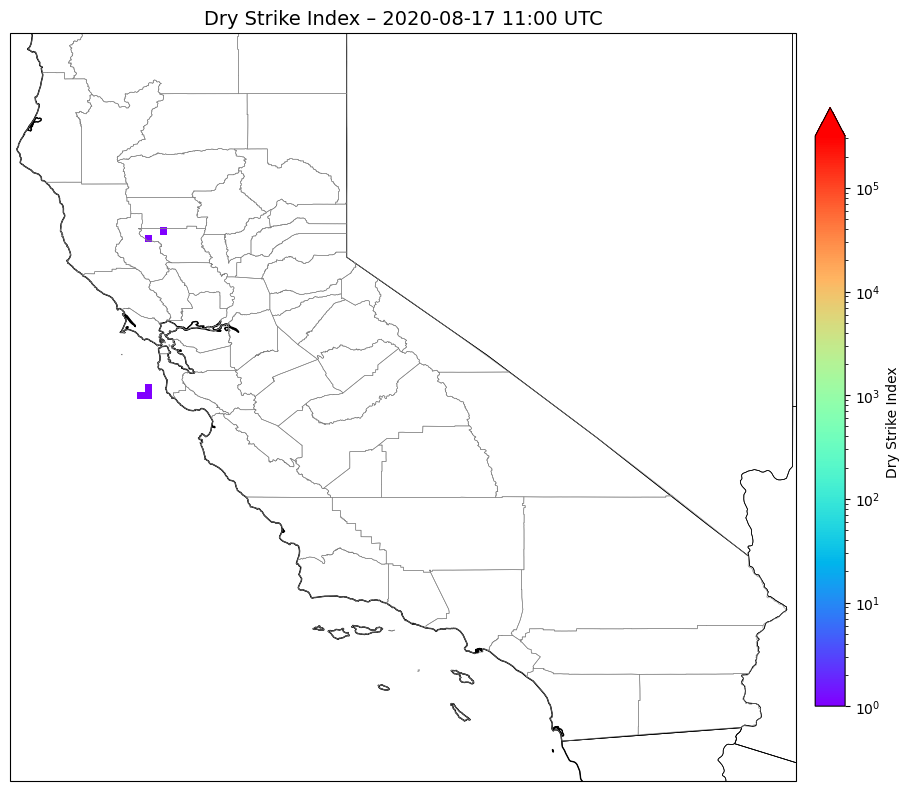

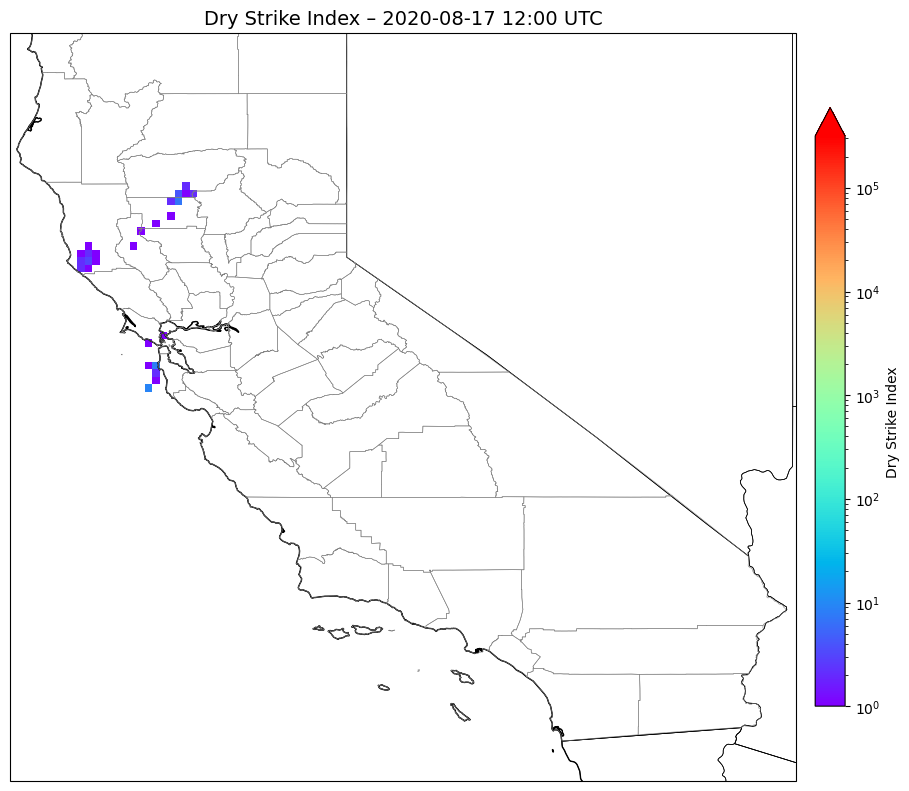

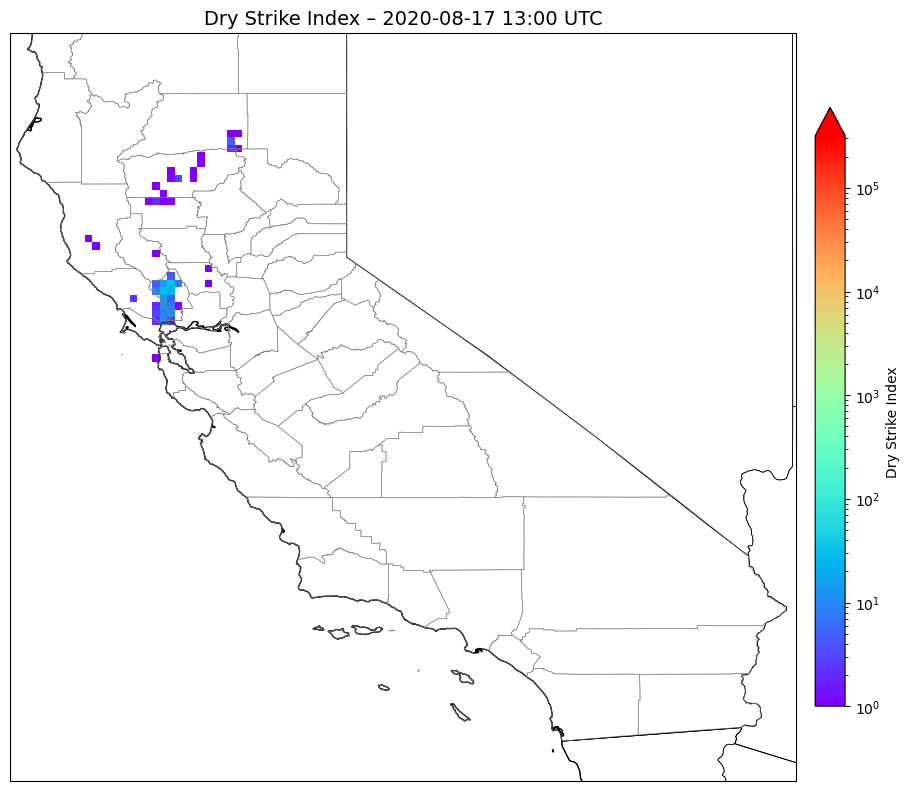

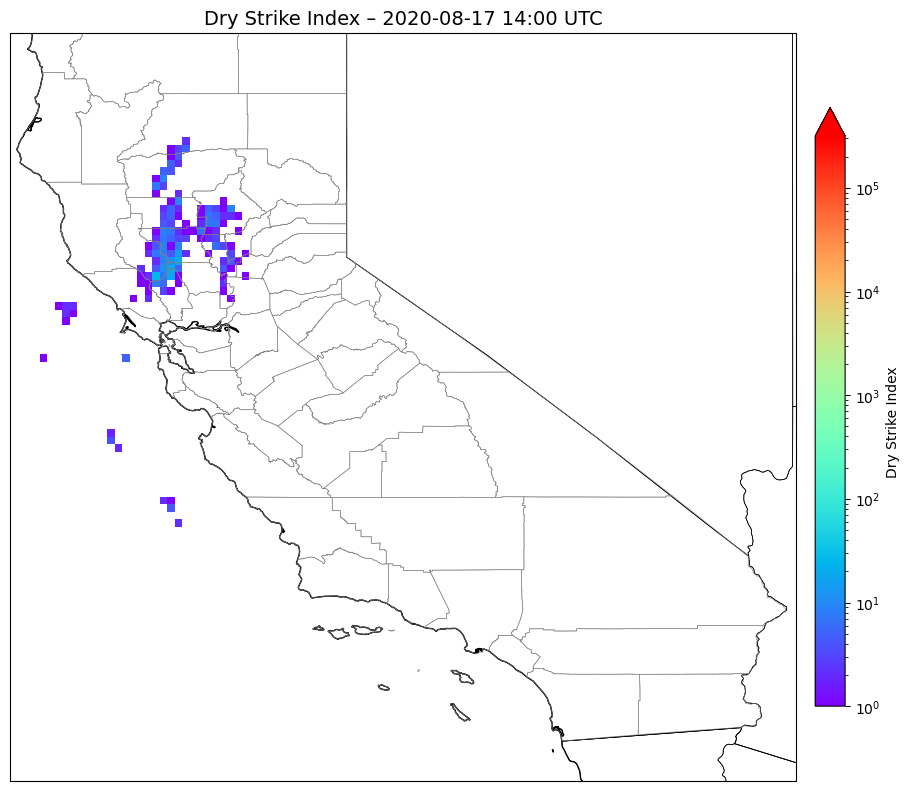

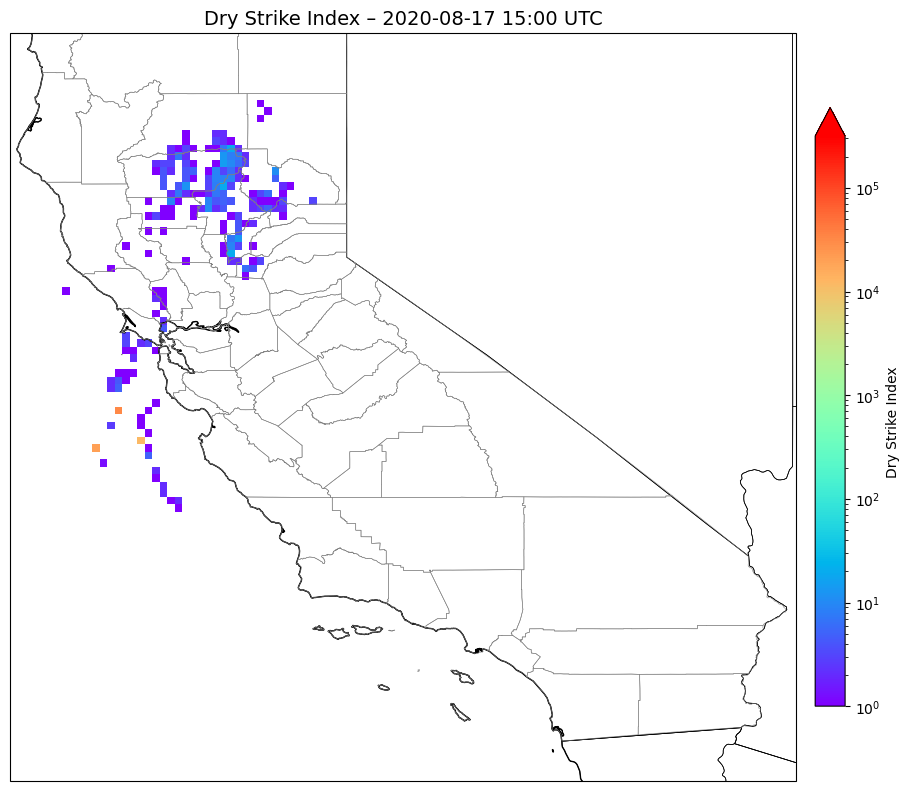

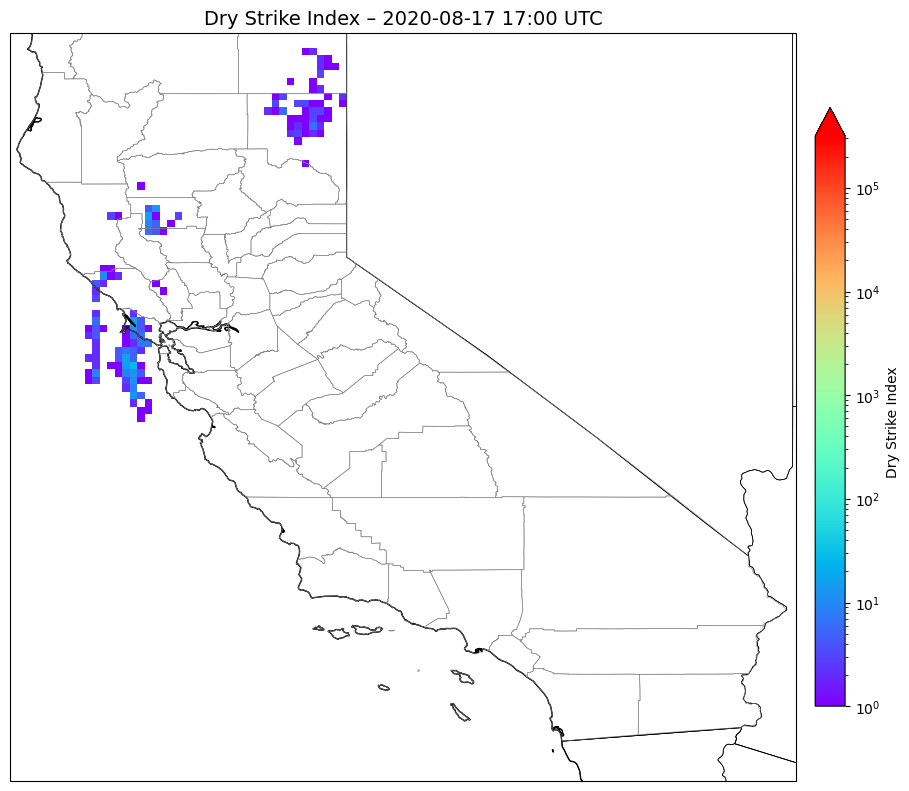

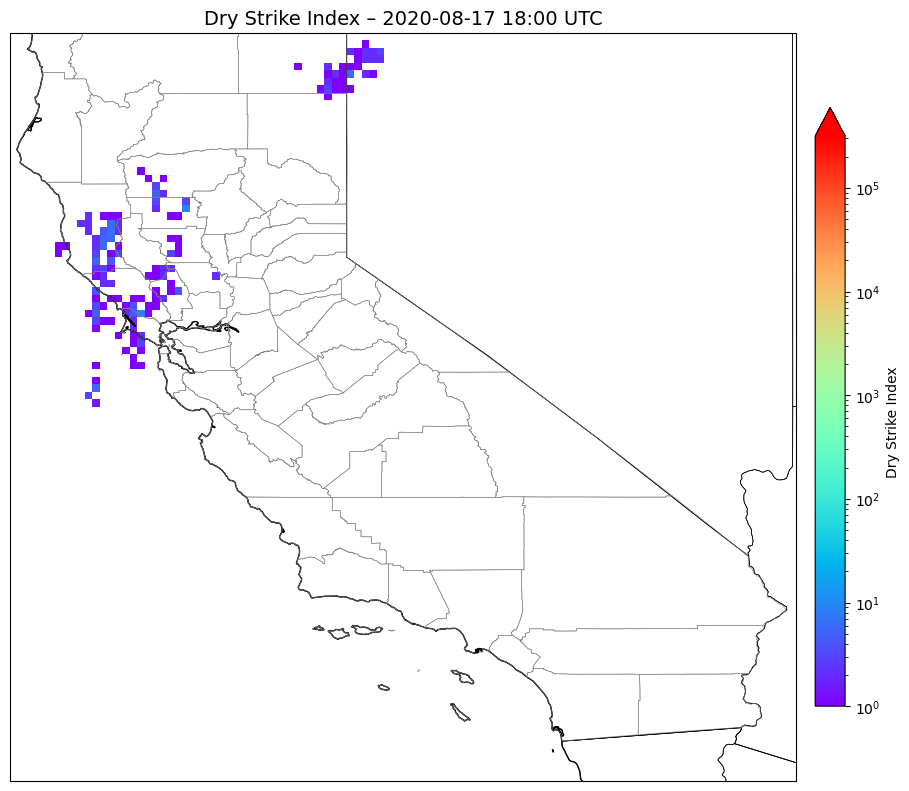

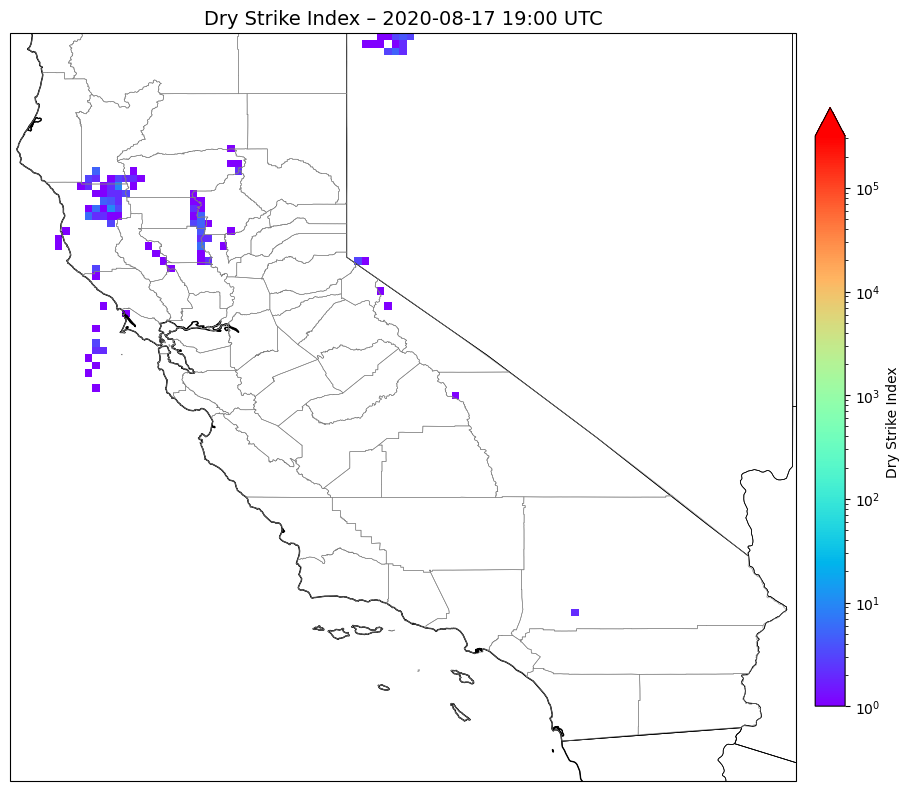

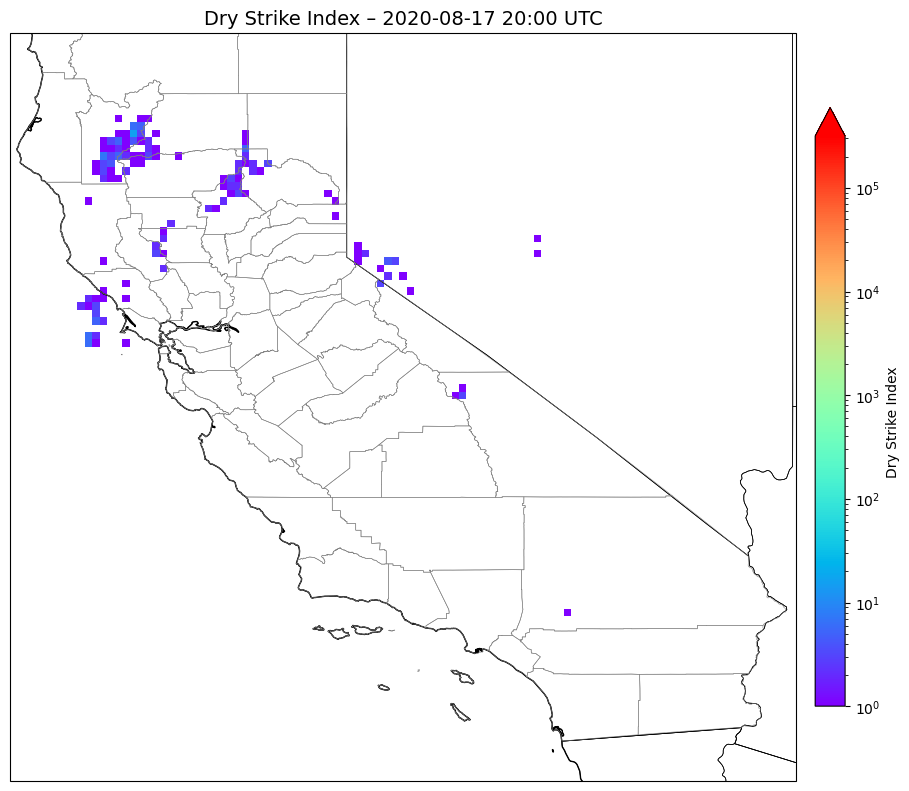

Done – produced 49 hourly DSI maps in D:\1Research\2025\NOAA_SatHack\figures\dsi_hourly


In [4]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import rasterio
from datetime import datetime, timedelta
import geopandas as gpd

# 0. DIRECTORIES & PARAMETERS
glm_dir    = r'D:\1Research\2025\NOAA_SatHack\data\glm_ca_subset'
dry_tif    = r'D:\1Research\2025\NOAA_SatHack\data\sentinel_ca\sentinel_flammability_0p1deg.tif'
out_dir    = r'D:\1Research\2025\NOAA_SatHack\figures\dsi_hourly'
os.makedirs(out_dir, exist_ok=True)

lon_min, lon_max = -124.5, -114.0
lat_min, lat_max =   32.0,    42.0
res = 0.1

# 1. LOAD THE DRYNESS (FLAMMABILITY) RASTER
with rasterio.open(dry_tif) as src:
    dryness = src.read(1)
nlat, nlon = dryness.shape

# Build edges for pcolormesh (must be one larger than dims)
lon_edges = np.linspace(lon_min, lon_min + nlon * res, nlon+1)
lat_edges = np.linspace(lat_min, lat_min + nlat * res, nlat+1)

# 2. BUILD HOURLY FLASH COUNTS
# dict of YYYYMMDDHH into 2D array
counts_hour = {}

pattern = re.compile(r'_c(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})')

for nc_path in glob.glob(os.path.join(glm_dir, '*.nc')):
    fname = os.path.basename(nc_path)
    m = pattern.search(fname)
    if not m:
        continue
    year = int(m.group(1))
    doy  = int(m.group(2))
    hr   = int(m.group(3))
    mn   = int(m.group(4))
    sc   = int(m.group(5))
    # convert year + day-of-year to date
    dt = datetime(year, 1, 1) + timedelta(days=doy-1,
                                         hours=hr,
                                         minutes=mn,
                                         seconds=sc)
    hour_key = dt.strftime('%Y%m%d%H')

    # lazy‐init grid
    if hour_key not in counts_hour:
        counts_hour[hour_key] = np.zeros((nlat, nlon), dtype=np.float64)

    # read flashes
    with Dataset(nc_path, 'r') as ds:
        lat = ds.variables['flash_lat'][:]
        lon = ds.variables['flash_lon'][:]

    # mask to our CA box
    mask = (
        (lon >= lon_min) & (lon < lon_min + nlon*res) &
        (lat >= lat_min) & (lat < lat_min + nlat*res)
    )
    lon_f = lon[mask]
    lat_f = lat[mask]
    if lon_f.size == 0:
        continue

    ix = np.digitize(lon_f, lon_edges) - 1
    iy = np.digitize(lat_f, lat_edges) - 1

    grid = counts_hour[hour_key]
    for x, y in zip(ix, iy):
        if 0 <= x < nlon and 0 <= y < nlat:
            grid[y, x] += 1

# 3. LOAD CALIFORNIA COUNTIES
# directory containing the extracted cb_2018_us_county_500k files
shp_dir  = r'D:\1Research\2025\NOAA_SatHack\cb_2018_us_county_500k'
# adjust the filename if yours differs
shp_path = os.path.join(shp_dir, 'cb_2018_us_county_500k.shp')

counties      = gpd.read_file(shp_path)
ca_counties   = counties[counties.STATEFP == '06']

# 4. PRE-COMPUTE GLOBAL vmax ACROSS ALL HOURS
all_maxima = []
for flash_grid in counts_hour.values():
    dsi = flash_grid * dryness
    dsi_masked = np.ma.masked_less(dsi, 1.0)
    if dsi_masked.count() > 0:
        all_maxima.append(dsi_masked.max())

global_vmax = float(max(all_maxima)) if all_maxima else 2.0
print(f"Fixed colorbar range: vmin=1 → vmax={global_vmax:.2f}")

# prepare a colormap and a single norm
cmap = plt.get_cmap('rainbow').copy()
cmap.set_under('white')
norm = LogNorm(vmin=1.0, vmax=global_vmax)

# 5. PLOT and SAVE ONE PNG PER HOUR 
for hour_key in sorted(counts_hour):
    flash_grid = counts_hour[hour_key]
    dsi        = flash_grid * dryness
    # masking <1 so those pixels draw white
    dsi_plot   = np.ma.masked_less(dsi, 1.0)

    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon_edges,
        lat_edges,
        dsi_plot,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
        shading='auto'
    )

    # map outlines
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)
    ax.add_geometries(
        ca_counties.geometry,
        crs=ccrs.PlateCarree(),
        edgecolor='gray',
        facecolor='none',
        linewidth=0.4
    )

    # colorbar
    cbar = plt.colorbar(mesh, ax=ax,
                        orientation='vertical',
                        pad=0.02, shrink=0.8,
                        extend='max')
    cbar.set_label('Dry Strike Index')

    # timestamp title
    dt_title = datetime.strptime(hour_key, '%Y%m%d%H')
    ax.set_title(dt_title.strftime('Dry Strike Index – %Y-%m-%d %H:00 UTC'),
                 fontsize=14)

    out_png = os.path.join(out_dir, f'DSI_{hour_key}.png')
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

print("Done – produced", len(counts_hour), "hourly DSI maps in", out_dir)
